## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = 15#np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples(scale_=0):
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=scale_, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples(4)

### Plot samples

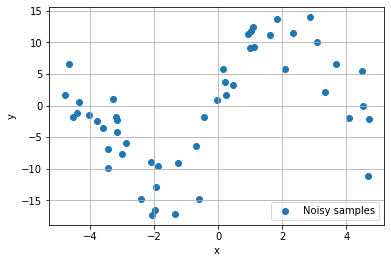

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

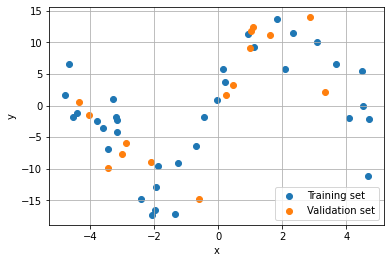

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### Solution

Let's try to check if regularization methods are expected to constraint the weights by experiment
We will do the same steps for Lasso (L1) and Ridge (L2) regularization
1. Fit model for every alpha from ALPHAS with make_model(degree=15, penalty, alpha)
2. Calculate comparative increase/decrease of weight on every step of alpha to the base. As base we will take minimum weight during this procedure
3. Show dynamic of comparative increase/decrease of weight graph
4. If our theory is correct final point of comparative increase/decrease of weight will stay on graph clother to zero than starting point

#### L1

In [9]:
### Fit model ###
dW_L1 = []
for alpha_ in ALPHAS:
    w = make_model(15, penalty='L1', alpha=alpha_).fit(X_train, y_train)['reg'].coef_
    dW_L1.append(w)

In [10]:
data_W_L1=pd.DataFrame(dW_L1)
data_W_L1['alpha']=ALPHAS

In [11]:
### Calculate comparative increase/decrease of weight ###
for i in range(1,DEGREES+1): 
    data_W_L1['w_diff'+str(i)]=data_W_L1[i].apply(lambda x: ((x - data_W_L1[i].min())/data_W_L1[i].min()))

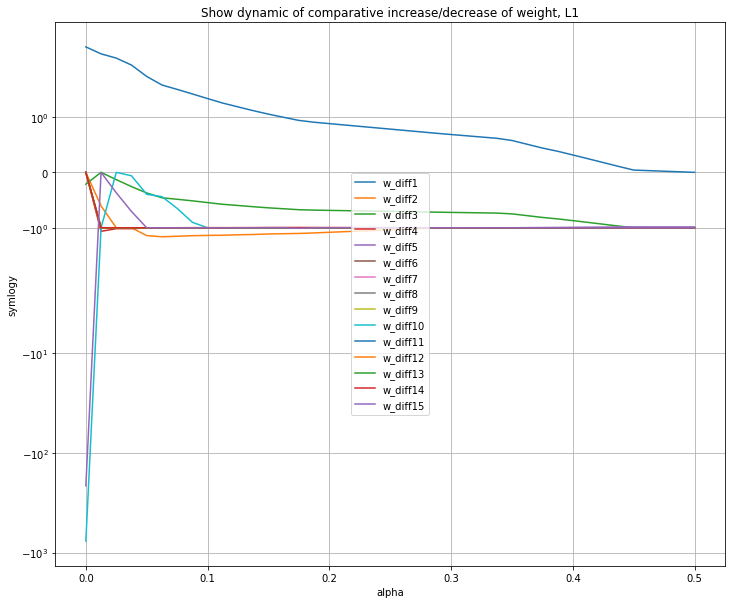

In [12]:
### Plot graph ###
plt.figure(figsize=(12, 10))
# gca stands for 'get current axis'
ax = plt.gca()
plt.yscale('symlog')
plt.ylabel('symlogy')
for i in range(1,DEGREES+1): 
    data_W_L1.plot(kind='line',x='alpha',y='w_diff'+str(i), ax=ax)
plt.grid(True)
plt.title('Show dynamic of comparative increase/decrease of weight, L1')
plt.legend(loc='center')    
plt.show()

#### L2

In [13]:
### Fit model ###
dW_L2 = []
for alpha_ in ALPHAS:
    w = make_model(15, penalty='L2', alpha=alpha_).fit(X_train, y_train)['reg'].coef_
    dW_L2.append(w)

In [14]:
data_W_L2=pd.DataFrame(dW_L2)
data_W_L2['alpha']=ALPHAS

In [15]:
### Calculate comparative increase/decrease of weight ###
for i in range(1,DEGREES+1): 
    data_W_L2['w_diff'+str(i)]=data_W_L2[i].apply(lambda x: ((x - data_W_L2[i].min())/data_W_L2[i].min()))

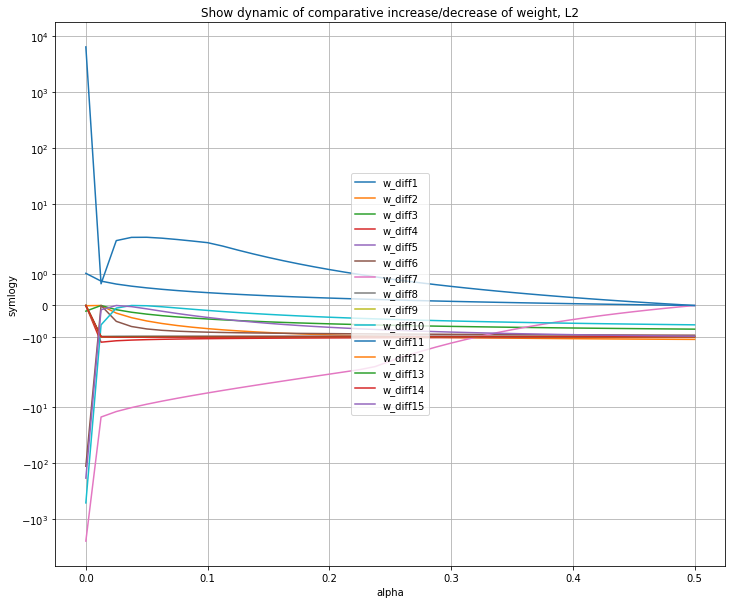

In [16]:
### Plot graph ###
plt.figure(figsize=(12, 10))
# gca stands for 'get current axis'
ax = plt.gca()
plt.yscale('symlog')
plt.ylabel('symlogy')
for i in range(1,DEGREES+1): 
    data_W_L2.plot(kind='line',x='alpha',y='w_diff'+str(i), ax=ax)
plt.grid(True)
plt.title('Show dynamic of comparative increase/decrease of weight, L2')
plt.legend(loc='center')    
plt.show()

#### Summary

1. Both regularizers (Ridge or Lasso) decrease weights at the same alpha.
2. Lasso reduces weights at the same alpha more aggressivly than Ridge
3. If alpha is made very large, then L1  zeroed the weights. This happens because L1  is not smooth and optimises not very well, so the values roll down to the point of a local minimum.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### Solution

Let's try to check if regularization methods are expected to constraint the weights by experiment
We will do the same steps for Lasso (L1) and Ridge (L2) regularization
1. Take data for every weight on alpha from ALPHAS from the preious excercise
2. Show dynamic of weights on graph
3. If our theory is correct than during L1 the most final points of weights will stop on graph on zero

#### L1

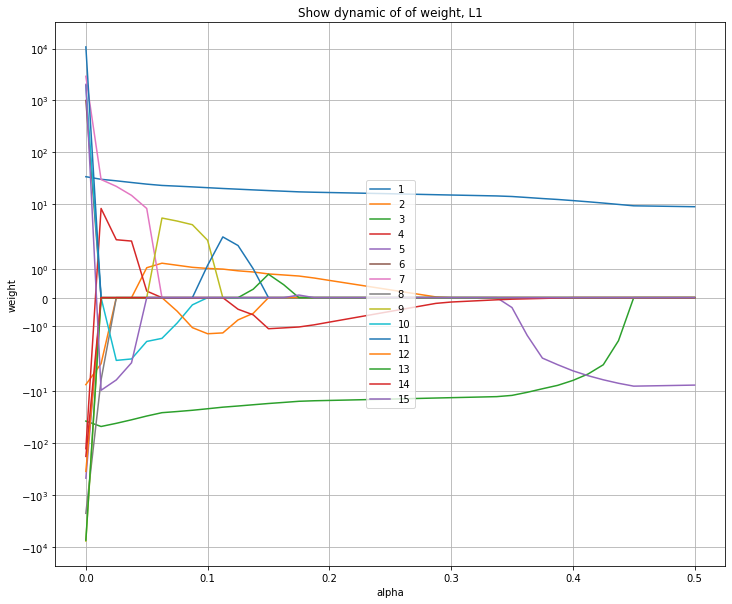

In [17]:
### Plot graph ###
plt.figure(figsize=(12, 10))
# gca stands for 'get current axis'
ax = plt.gca()
plt.yscale('symlog')
plt.ylabel('weight')
for i in range(1,DEGREES+1): 
    data_W_L1.plot(kind='line',x='alpha',y=i, ax=ax)
plt.grid(True)
plt.title('Show dynamic of of weight, L1')
plt.legend(loc='center')    
plt.show()

#### L2

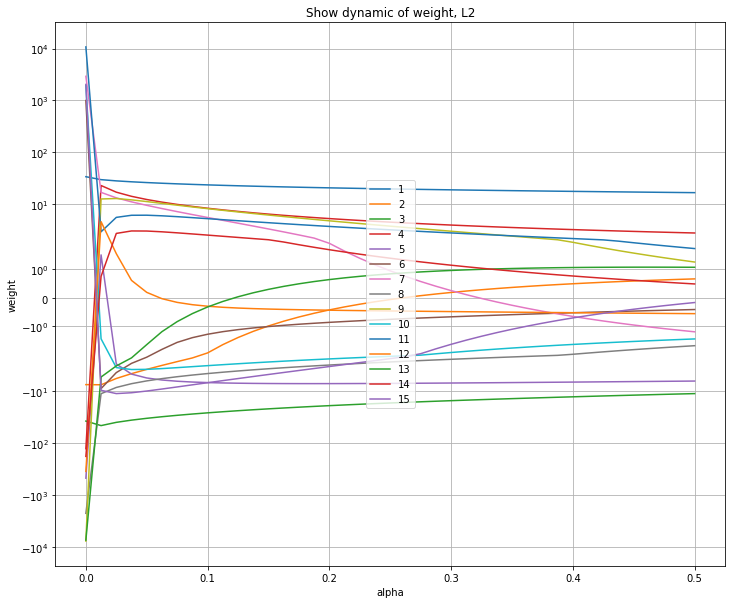

In [18]:
### Plot graph ###
plt.figure(figsize=(12, 10))
# gca stands for 'get current axis'
ax = plt.gca()
plt.yscale('symlog')
plt.ylabel('weight')
for i in range(1,DEGREES+1): 
    data_W_L2.plot(kind='line',x='alpha',y=i, ax=ax)
plt.grid(True)
plt.title('Show dynamic of weight, L2')
plt.legend(loc='center')    
plt.show()

#### Summary

1. With bigger alpha L1  zeroed the weights. And this behaviour of L1 is not the same for L2.
2. This happens because L1  is not smooth and optimises not very well, so the values roll down to the point of a local minimum.
3. According to this quality L1 can also be used for feature selection and exluding non informative features.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

#### Summary

1. The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
2. In case of multivariate data, this is done feature-wise (in other words independently for each column of the data).
Given the distribution of the data, each value in the dataset will have the mean value subtracted, and then divided by the 
standard deviation of the whole dataset (or feature in the multivariate case).
Source: https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
3. Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
4. For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
Source: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler